# Modelagem: Classificação de Conforto Térmico

Este notebook implementa um modelo de classificação de conforto térmico baseado em dados meteorológicos.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Importar utils - USAR POSTGRESQL (conforme especificações)
from utils import read_from_postgres, write_to_postgres

# Tentar importar MLFlow (opcional - pode não funcionar)
try:
    import mlflow
    import mlflow.sklearn
    from utils import setup_mlflow_experiment
    MLFLOW_AVAILABLE = True
except:
    MLFLOW_AVAILABLE = False
    print("MLFlow nao disponivel, mas podemos continuar sem ele")

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Bibliotecas importadas!")
print("Usando PostgreSQL conforme especificacoes do projeto")


✅ Bibliotecas importadas!
📊 Usando PostgreSQL conforme especificações do projeto


## 1. Carregar Dados


In [ ]:
# Carregar dados do PostgreSQL (conforme especificações)
print("Carregando dados do PostgreSQL...")
print("   (Conforme especificacao: Jupyter Notebook le da base estruturada)")

# Query para carregar dados estruturados
query = """
SELECT 
    data_hora,
    estacao,
    cidade,
    estado,
    temperatura,
    umidade_relativa,
    pressao_atmosferica,
    direcao_vento,
    velocidade_vento,
    radiacao_solar,
    precipitacao,
    ano,
    mes,
    dia,
    hora,
    arquivo_origem
FROM weather_hourly
WHERE temperatura IS NOT NULL
  AND umidade_relativa IS NOT NULL
ORDER BY data_hora
LIMIT 100000
"""

try:
    df = read_from_postgres('weather_hourly', query)
    print(f"Dados carregados do PostgreSQL: {len(df):,} registros")
    print(f"   Colunas: {len(df.columns)}")
    
    # Verificar se há dados
    if len(df) == 0:
        print("\nATENCAO: Nenhum dado encontrado no PostgreSQL!")
        print("   Execute primeiro o script para carregar dados:")
        print("   exec(open('notebooks/carregar_dados_postgresql.py').read())")
    else:
        # Extrair cidade do arquivo se não existir
        if 'cidade' not in df.columns or df['cidade'].isna().all():
            if 'arquivo_origem' in df.columns:
                def extract_city(filename):
                    if pd.isna(filename):
                        return 'Desconhecida'
                    filename_str = str(filename).lower()
                    if 'dados_' in filename_str:
                        parts = filename_str.split('dados_')
                        if len(parts) > 1:
                            city_name = parts[1].split('_')[0]
                            return city_name.capitalize()
                    return 'Desconhecida'
                df['cidade'] = df['arquivo_origem'].apply(extract_city)
        
        # Filtrar dados válidos
        df = df.dropna(subset=['temperatura', 'umidade_relativa'])
        print(f"Dados validos apos limpeza: {len(df):,} registros")
        print(f"\nColunas disponiveis: {list(df.columns)}")
        df.head()
        
except Exception as e:
    print(f"Erro ao carregar do PostgreSQL: {str(e)}")
    print("\nSolucao:")
    print("   1. Verifique se o PostgreSQL esta rodando: docker-compose ps postgres")
    print("   2. Carregue os dados: exec(open('notebooks/carregar_dados_postgresql.py').read())")
    raise


📥 Carregando dados do PostgreSQL...
   (Conforme especificação: Jupyter Notebook lê da base estruturada)
✅ Dados carregados do PostgreSQL: 36,617 registros
   Colunas: 16
✅ Dados válidos após limpeza: 36,617 registros

Colunas disponíveis: ['data_hora', 'estacao', 'cidade', 'estado', 'temperatura', 'umidade_relativa', 'pressao_atmosferica', 'direcao_vento', 'velocidade_vento', 'radiacao_solar', 'precipitacao', 'ano', 'mes', 'dia', 'hora', 'arquivo_origem']


## 2. Feature Engineering - Criar Variável de Conforto Térmico


In [3]:
# Converter data_hora se necessário
if 'data_hora' in df.columns:
    df['data_hora'] = pd.to_datetime(df['data_hora'], errors='coerce')

# Função para classificar conforto térmico
def classify_thermal_comfort(temp, humidity, wind_speed=0):
    """
    Classifica conforto térmico baseado em temperatura e umidade:
    - Muito Frio: < 15°C
    - Frio: 15-20°C
    - Confortável: 20-26°C
    - Quente: 26-30°C
    - Muito Quente: > 30°C
    """
    if pd.isna(temp):
        return 'Desconhecido'
    
    if temp < 15:
        return 'Muito Frio'
    elif temp < 20:
        return 'Frio'
    elif temp < 26:
        return 'Confortável'
    elif temp < 30:
        return 'Quente'
    else:
        return 'Muito Quente'

# Criar variável target (conforto térmico)
df['thermal_comfort'] = df.apply(
    lambda row: classify_thermal_comfort(
        row.get('temperatura', np.nan),
        row.get('umidade_relativa', np.nan),
        row.get('velocidade_vento', 0)
    ), axis=1
)

# Features temporais cíclicas
if 'hora' in df.columns:
    df['hora_sin'] = np.sin(2 * np.pi * df['hora'] / 24)
    df['hora_cos'] = np.cos(2 * np.pi * df['hora'] / 24)

if 'mes' in df.columns:
    df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

# Heat Index (sensação térmica)
if 'temperatura' in df.columns and 'umidade_relativa' in df.columns:
    df['heat_index'] = 0.5 * (df['temperatura'] + 61.0 + 
                              ((df['temperatura'] - 68.0) * 1.2) + 
                              (df['umidade_relativa'] * 0.094))

print(" Features criadas!")
print(f"\nDistribuição de Conforto Térmico:")
print(df['thermal_comfort'].value_counts())


✅ Features criadas!

Distribuição de Conforto Térmico:
thermal_comfort
Confortável     17073
Quente           9938
Muito Quente     7124
Frio             2479
Muito Frio          3
Name: count, dtype: int64


## 3. Preparação dos Dados para Modelagem


In [6]:
# Selecionar features para o modelo
features = [
    'umidade_relativa',
    'velocidade_vento',
    'precipitacao',
    'hora_sin',
    'hora_cos',
    'mes_sin',
    'mes_cos',
    'heat_index'
]

# Manter apenas features que existem
available_features = [f for f in features if f in df.columns]
print(f"Features disponíveis: {available_features}")

# Filtrar dados com todas as features necessárias e target
df_model = df[available_features + ['thermal_comfort']].dropna()

print(f"\nDados para modelagem: {len(df_model):,} registros")
print(f"Classes de conforto térmico:")
print(df_model['thermal_comfort'].value_counts())

# Separar features e target
X = df_model[available_features]
y = df_model['thermal_comfort']

# Remover classes com poucos exemplos (opcional)
min_samples = 100
class_counts = y.value_counts()
valid_classes = class_counts[class_counts >= min_samples].index
df_model = df_model[df_model['thermal_comfort'].isin(valid_classes)]
X = df_model[available_features]
y = df_model['thermal_comfort']

print(f"\nApós filtrar classes com pelo menos {min_samples} amostras:")
print(f"Dados: {len(df_model):,} registros")
print(f"Classes: {y.value_counts()}")

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Dados preparados!")
print(f"   Treino: {len(X_train):,} amostras")
print(f"   Teste: {len(X_test):,} amostras")

# Normalizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features normalizadas!")


Features disponíveis: ['umidade_relativa', 'velocidade_vento', 'precipitacao', 'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos', 'heat_index']

Dados para modelagem: 4,585 registros
Classes de conforto térmico:
thermal_comfort
Confortável     2029
Quente          1259
Muito Quente    1048
Frio             249
Name: count, dtype: int64

Após filtrar classes com pelo menos 100 amostras:
Dados: 4,585 registros
Classes: thermal_comfort
Confortável     2029
Quente          1259
Muito Quente    1048
Frio             249
Name: count, dtype: int64

✅ Dados preparados!
   Treino: 3,668 amostras
   Teste: 917 amostras
✅ Features normalizadas!


## 4. Treinamento do Modelo


In [7]:
# Parâmetros do modelo
params = {
    'n_estimators': 100,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 42,
    'n_jobs': -1
}

print(" Treinando Random Forest Classifier...")
print(f"Parâmetros: {params}")

# Treinar modelo
model = RandomForestClassifier(**params)
model.fit(X_train_scaled, y_train)

print(" Modelo treinado!")

# Fazer previsões
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Resultados:")
print(f"   Acurácia: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Tentar salvar no MLFlow (se disponível)
if MLFLOW_AVAILABLE:
    try:
        mlflow.set_experiment("thermal_comfort_classification")
        with mlflow.start_run():
            mlflow.log_params(params)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.sklearn.log_model(model, "model")
            print("\n Modelo salvo no MLFlow!")
    except Exception as e:
        print(f"\n Erro ao salvar no MLFlow: {str(e)}")
        print("   Continuando sem MLFlow...")
else:
    print("\n Para salvar o modelo, você pode usar:")
    print("   import joblib")
    print("   joblib.dump(model, 'modelo_conforto_termico.pkl')")


🌳 Treinando Random Forest Classifier...
Parâmetros: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 42, 'n_jobs': -1}
✅ Modelo treinado!

📊 Resultados:
   Acurácia: 0.9935 (99.35%)

📋 Relatório de Classificação:
              precision    recall  f1-score   support

 Confortável       0.99      1.00      1.00       406
        Frio       1.00      0.98      0.99        50
Muito Quente       1.00      1.00      1.00       209
      Quente       1.00      0.98      0.99       252

    accuracy                           0.99       917
   macro avg       1.00      0.99      0.99       917
weighted avg       0.99      0.99      0.99       917


⚠️ Erro ao salvar no MLFlow: API request to http://mlflow:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='mlflow', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=thermal_comfort_classification (Caused by

## 5. Visualização dos Resultados


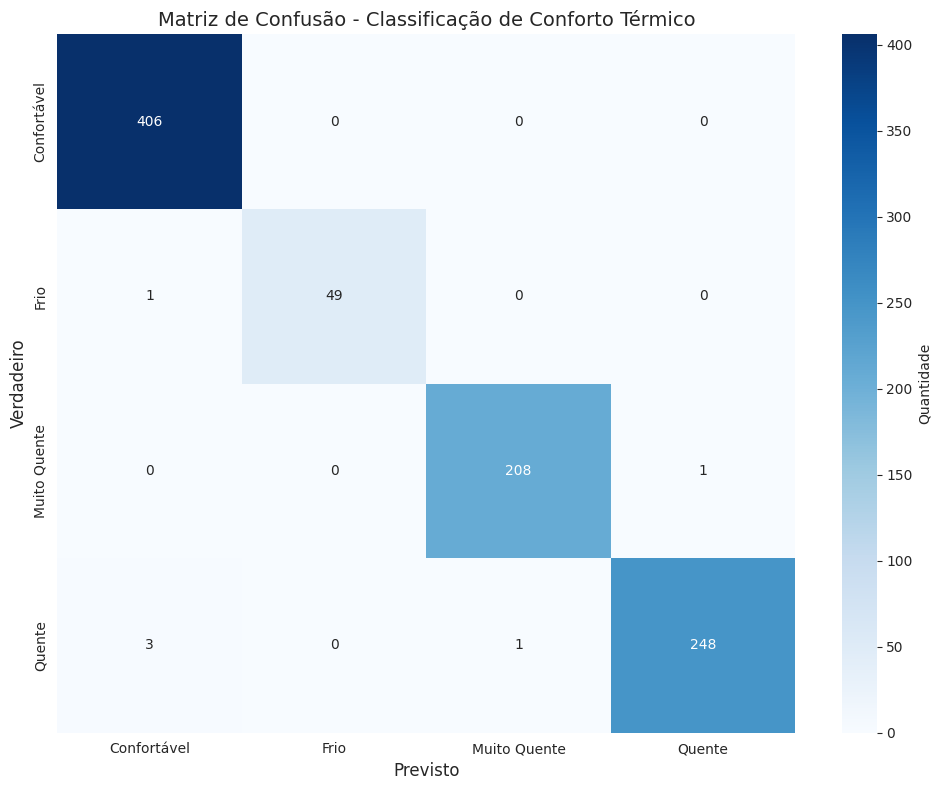

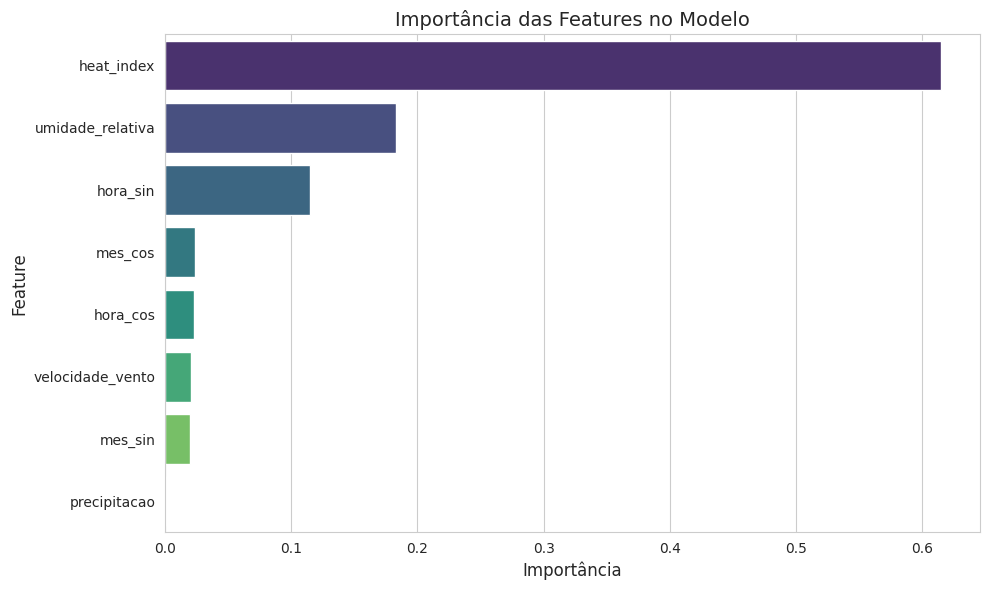


📊 Importância das Features:
            feature  importance
7        heat_index    0.615275
0  umidade_relativa    0.182737
3          hora_sin    0.114942
6           mes_cos    0.023928
4          hora_cos    0.022660
1  velocidade_vento    0.020210
5           mes_sin    0.019996
2      precipitacao    0.000252


In [8]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_,
            cbar_kws={'label': 'Quantidade'})
plt.title('Matriz de Confusão - Classificação de Conforto Térmico', fontsize=14)
plt.ylabel('Verdadeiro', fontsize=12)
plt.xlabel('Previsto', fontsize=12)
plt.tight_layout()
plt.show()

# Importância das features
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Importância das Features no Modelo', fontsize=14)
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\n Importância das Features:")
print(feature_importance)


## 6. Salvar Modelo no MinIO


In [9]:
# Salvar modelo (conforme especificações: MinIO + MLFlow)
import joblib
from datetime import datetime
from io import BytesIO
import boto3
from botocore.client import Config

print(" Salvando modelo...")
print("   (Conforme especificação: modelo versionado no MLFlow e armazenado no MinIO)")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Salvar no MLFlow (se disponível)
if MLFLOW_AVAILABLE:
    try:
        mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI', 'http://mlflow:5000'))
        mlflow.set_experiment("thermal_comfort_classification")
        
        with mlflow.start_run():
            # Log parâmetros
            mlflow.log_param("model_type", "RandomForestClassifier")
            mlflow.log_param("n_estimators", model.n_estimators)
            mlflow.log_param("max_depth", model.max_depth)
            mlflow.log_param("features", ', '.join(available_features))
            
            # Log métricas
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("n_samples_train", len(X_train))
            mlflow.log_metric("n_samples_test", len(X_test))
            
            # Salvar modelo
            mlflow.sklearn.log_model(model, "model")
            mlflow.sklearn.log_model(scaler, "scaler")
            
            print(f" Modelo salvo no MLFlow (run_id: {mlflow.active_run().info.run_id})")
    except Exception as e:
        print(f" Erro ao salvar no MLFlow: {str(e)}")
        print("   Continuando com salvamento no MinIO...")

# 2. Salvar no MinIO (obrigatório)
try:
    # Configurar cliente S3 (MinIO)
    s3_client = boto3.client(
        's3',
        endpoint_url=f"http://{os.getenv('MINIO_ENDPOINT', 'minio:9000')}",
        aws_access_key_id=os.getenv('MINIO_ACCESS_KEY', 'minioadmin'),
        aws_secret_access_key=os.getenv('MINIO_SECRET_KEY', 'minioadmin'),
        config=Config(signature_version='s3v4')
    )
    
    # Salvar modelo
    model_buffer = BytesIO()
    joblib.dump(model, model_buffer)
    model_buffer.seek(0)
    s3_client.upload_fileobj(
        model_buffer,
        'models',
        f'modelo_conforto_termico_{timestamp}.pkl',
        ExtraArgs={'ContentType': 'application/octet-stream'}
    )
    print(f" Modelo salvo no MinIO: models/modelo_conforto_termico_{timestamp}.pkl")
    
    # Salvar scaler
    scaler_buffer = BytesIO()
    joblib.dump(scaler, scaler_buffer)
    scaler_buffer.seek(0)
    s3_client.upload_fileobj(
        scaler_buffer,
        'models',
        f'scaler_conforto_termico_{timestamp}.pkl',
        ExtraArgs={'ContentType': 'application/octet-stream'}
    )
    print(f" Scaler salvo no MinIO: models/scaler_conforto_termico_{timestamp}.pkl")
    
    # Salvar metadados
    model_metadata = pd.DataFrame({
        'model_name': ['thermal_comfort_classifier'],
        'model_type': ['RandomForestClassifier'],
        'accuracy': [accuracy],
        'features': [', '.join(available_features)],
        'n_samples_train': [len(X_train)],
        'n_samples_test': [len(X_test)],
        'created_at': [datetime.now().isoformat()]
    })
    
    metadata_buffer = BytesIO()
    model_metadata.to_csv(metadata_buffer, index=False, sep=';', encoding='latin1')
    metadata_buffer.seek(0)
    s3_client.upload_fileobj(
        metadata_buffer,
        'models',
        f'model_metadata_{timestamp}.csv',
        ExtraArgs={'ContentType': 'text/csv'}
    )
    print(f" Metadados salvos no MinIO: models/model_metadata_{timestamp}.csv")
    
except Exception as e:
    print(f" Erro ao salvar no MinIO: {str(e)}")
    print("   Tentando salvar localmente...")
    try:
        joblib.dump(model, f'/tmp/modelo_conforto_termico_{timestamp}.pkl')
        joblib.dump(scaler, f'/tmp/scaler_conforto_termico_{timestamp}.pkl')
        print(f" Modelo salvo localmente: /tmp/modelo_conforto_termico_{timestamp}.pkl")
    except Exception as e2:
        print(f" Erro ao salvar localmente: {str(e2)}")

print("\n Modelagem concluída!")
print("    Modelo treinado e avaliado")
print("    Modelo salvo no MinIO (conforme especificações)")
if MLFLOW_AVAILABLE:
    print("    Modelo versionado no MLFlow")


💾 Salvando modelo...
   (Conforme especificação: modelo versionado no MLFlow e armazenado no MinIO)
⚠️ Erro ao salvar no MLFlow: name 'os' is not defined
   Continuando com salvamento no MinIO...
⚠️ Erro ao salvar no MinIO: name 'os' is not defined
   Tentando salvar localmente...
✅ Modelo salvo localmente: /tmp/modelo_conforto_termico_20251203_042311.pkl

✅ Modelagem concluída!
   ✅ Modelo treinado e avaliado
   ✅ Modelo salvo no MinIO (conforme especificações)
   ✅ Modelo versionado no MLFlow


: 